## Policy gradient

In [881]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PG.agent import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load per hour bitcoin data

In [427]:
# data proccess
DATA_PATH = './per_min_data/'

data = pd.read_csv(DATA_PATH + os.listdir(DATA_PATH)[0])

data.iloc[:,6] = pd.to_datetime(data.iloc[:,6], unit='ms').apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
data.iloc[:,6] = pd.to_datetime(data.iloc[:,6])
data.set_index('Close time', inplace=True)
data = data.iloc[:,1:6]
# Aggregate per hour
data = data.resample('60T').agg({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Close':'last',
    'Volume':'sum'
    })
data = data.dropna() 

In [428]:
data

,Open,High,Low,Close,Volume
Close time,,,,,
2018-04-27 14:00:00,9226.97,9290.00,9202.00,9288.88,1401.058675
2018-04-27 15:00:00,9280.14,9288.88,9210.01,9241.21,1359.959170
2018-04-27 16:00:00,9241.20,9328.26,9241.00,9282.10,1395.512101
2018-04-27 17:00:00,9286.01,9319.99,9266.00,9290.10,1122.230082
2018-04-27 18:00:00,9290.10,9296.31,9213.80,9230.89,1001.907142
2018-04-27 19:00:00,9230.89,9250.56,9075.01,9089.00,2097.185440
2018-04-27 20:00:00,9089.12,9163.38,8940.00,8970.00,3084.066108
2018-04-27 21:00:00,8969.99,9053.00,8909.83,8975.35,1911.233654
2018-04-27 22:00:00,8975.36,9093.09,8975.36,9031.00,1077.087976


Creat an agent

In [1008]:
agent = Agent(data, train_frac = 0.8, traj_len = 100, batch_size = 4)

number of train data:  5336 number of validation data:  400 number of test data:  800
trajectory length is:  100


In [312]:
agent.model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 5)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 500)           1012000   
_________________________________________________________________
raw_policy (TimeDistributed) (None, 50, 2)             1002      
Total params: 1,013,002
Trainable params: 1,013,002
Non-trainable params: 0
_________________________________________________________________


In [971]:
agent.data_raw

array([[9226.97    , 9290.      , 9202.      , 9288.88    , 1401.058675],
       [9280.14    , 9288.88    , 9210.01    , 9241.21    , 1359.95917 ],
       [9241.2     , 9328.26    , 9241.      , 9282.1     , 1395.512101],
       ...,
       [3429.28    , 3440.7     , 3427.16    , 3436.56    ,  762.436383],
       [3435.82    , 3440.81    , 3426.01    , 3427.2     ,  899.702027],
       [3427.2     , 3436.04    , 3425.      , 3428.3     ,  854.34059 ]])

In [972]:
agent.data_scaled

array([[ 2.67394871e-02,  2.79946256e-02,  2.69220158e-02,
         2.70825929e-02, -2.92987688e-04],
       [ 8.44184603e-01,  1.00769187e-02,  1.50293793e-01,
        -7.05745688e-01, -6.28594020e-02],
       [-5.71470332e-01,  6.56700226e-01,  5.03228309e-01,
         6.55912025e-01,  5.39377401e-02],
       ...,
       [-4.84272813e-01, -1.17370520e-02,  1.96654070e-01,
         3.40757403e-01, -9.63957730e-01],
       [ 2.97796324e-01,  3.27457114e-02, -2.06652573e-02,
        -3.61378626e-01,  3.47584810e-01],
       [-3.30633387e-01, -1.78169374e-01, -1.48852009e-02,
         7.27900640e-02, -1.09006948e-01]])

Train the agent

In [1026]:
agent.train(100)

Random sampling 13 trajectors per epoch.
epoch 0...
step 0, loss: 38.458457946777344, sharpe ratio: 0.03314501536196898
step 1, loss: 38.47896194458008, sharpe ratio: 0.11186135967392817
step 2, loss: 38.383079528808594, sharpe ratio: -0.07590516853827635
step 3, loss: 38.36991500854492, sharpe ratio: -0.046139434672991864
step 4, loss: 38.38270568847656, sharpe ratio: -0.007817099523337276
step 5, loss: 38.33241653442383, sharpe ratio: -0.059853017514033616
step 6, loss: 38.3465690612793, sharpe ratio: -0.00764144639093835
step 7, loss: 38.37559127807617, sharpe ratio: 0.06684017845131147
step 8, loss: 38.294734954833984, sharpe ratio: -0.06593218863083788
step 9, loss: 38.27760314941406, sharpe ratio: -0.06595034532903933
step 10, loss: 38.29530715942383, sharpe ratio: -0.013842621786559116
step 11, loss: 38.295989990234375, sharpe ratio: -0.002260642233746819
step 12, loss: 38.27686309814453, sharpe ratio: 0.007181447137809385
validation sharpe ratio: 0.04280213564031686
epoch 0: lo

step 1, loss: 37.00373077392578, sharpe ratio: -0.021560626599606628
step 2, loss: 36.987457275390625, sharpe ratio: -0.05063544673697101
step 3, loss: 36.95005798339844, sharpe ratio: -0.0698784449546743
step 4, loss: 37.028133392333984, sharpe ratio: 0.07066955620600776
step 5, loss: 37.009071350097656, sharpe ratio: 0.06805727249703225
step 6, loss: 36.94791793823242, sharpe ratio: -0.020624582807326063
step 7, loss: 36.90911102294922, sharpe ratio: -0.05696036517066112
step 8, loss: 36.92042541503906, sharpe ratio: -0.016906152580025584
step 9, loss: 36.944942474365234, sharpe ratio: 0.06939143662525249
step 10, loss: 36.911216735839844, sharpe ratio: 0.020723103542859254
step 11, loss: 36.87653732299805, sharpe ratio: -0.02590210542786714
step 12, loss: 36.866554260253906, sharpe ratio: -0.011065157757128158
validation sharpe ratio: 0.04696218230157179
epoch 8: loss: 36.952369689941406, learning rate: 9.999998292187229e-05
epoch 9...
step 0, loss: 36.85558319091797, sharpe ratio: 

step 3, loss: 35.621829986572266, sharpe ratio: -0.005061245603752483
step 4, loss: 35.64020538330078, sharpe ratio: 0.05347963212875942
step 5, loss: 35.61172866821289, sharpe ratio: 0.03453124604755357
step 6, loss: 35.61831283569336, sharpe ratio: 0.057896899678955685
step 7, loss: 35.60698318481445, sharpe ratio: 0.06718028495243888
step 8, loss: 35.50523376464844, sharpe ratio: -0.08985851383454121
step 9, loss: 35.56990432739258, sharpe ratio: 0.03037505237953892
step 10, loss: 35.52898025512695, sharpe ratio: -0.008291196009408672
step 11, loss: 35.53547286987305, sharpe ratio: 0.018204582026634622
step 12, loss: 35.52581787109375, sharpe ratio: 0.03537442539715914
validation sharpe ratio: 0.04900194193930532
epoch 16: loss: 35.5955924987793, learning rate: 9.999998292187229e-05
epoch 17...
step 0, loss: 35.47085952758789, sharpe ratio: -0.05357780443070622
step 1, loss: 35.5041618347168, sharpe ratio: 0.03782163334687446
step 2, loss: 35.448036193847656, sharpe ratio: -0.042174

step 5, loss: 34.21833419799805, sharpe ratio: -0.08813006983707558
step 6, loss: 34.288536071777344, sharpe ratio: 0.06680928463645092
step 7, loss: 34.27670669555664, sharpe ratio: 0.06545221922093072
step 8, loss: 34.259605407714844, sharpe ratio: 0.05356963529617764
step 9, loss: 34.236995697021484, sharpe ratio: 0.019687429326066878
step 10, loss: 34.205814361572266, sharpe ratio: -0.003299211596672888
step 11, loss: 34.216949462890625, sharpe ratio: 0.033733901218236786
step 12, loss: 34.173954010009766, sharpe ratio: -0.021628176516555363
validation sharpe ratio: 0.057035179710935774
epoch 24: loss: 34.25487518310547, learning rate: 9.999998292187229e-05
epoch 25...
step 0, loss: 34.16582489013672, sharpe ratio: -0.015150090330588966
step 1, loss: 34.20241928100586, sharpe ratio: 0.07406919797600313
step 2, loss: 34.108863830566406, sharpe ratio: -0.05758112041893708
step 3, loss: 34.12947082519531, sharpe ratio: 0.005373351863217321
step 4, loss: 34.172122955322266, sharpe rati

step 7, loss: 32.970924377441406, sharpe ratio: 0.02921860691820026
step 8, loss: 32.936973571777344, sharpe ratio: -0.01142634815116961
step 9, loss: 32.90687561035156, sharpe ratio: -0.0486586440822781
step 10, loss: 32.90241622924805, sharpe ratio: -0.02629708364465755
step 11, loss: 32.94782638549805, sharpe ratio: 0.06613664429679267
step 12, loss: 32.857242584228516, sharpe ratio: -0.044518905563239314
validation sharpe ratio: 0.04549943641494446
epoch 32: loss: 32.96624755859375, learning rate: 9.999998292187229e-05
epoch 33...
step 0, loss: 32.90021896362305, sharpe ratio: 0.03618952024515355
step 1, loss: 32.82585906982422, sharpe ratio: -0.061590633978215736
step 2, loss: 32.834938049316406, sharpe ratio: -0.028574306235792647
step 3, loss: 32.86281967163086, sharpe ratio: 0.0016212036625069548
step 4, loss: 32.83393096923828, sharpe ratio: 0.0034796307149516526
step 5, loss: 32.85321044921875, sharpe ratio: 0.051874697647027145
step 6, loss: 32.795143127441406, sharpe ratio:

step 9, loss: 31.699779510498047, sharpe ratio: 0.03498107507473312
step 10, loss: 31.664844512939453, sharpe ratio: -0.009162072128386222
step 11, loss: 31.683547973632812, sharpe ratio: 0.05017419096381587
step 12, loss: 31.642427444458008, sharpe ratio: 0.007911163409951053
validation sharpe ratio: 0.04828520553790877
epoch 40: loss: 31.72886085510254, learning rate: 9.999998292187229e-05
epoch 41...
step 0, loss: 31.617874145507812, sharpe ratio: -0.049697845099332894
step 1, loss: 31.585224151611328, sharpe ratio: -0.04992091444206156
step 2, loss: 31.607280731201172, sharpe ratio: -0.001051102058122956
step 3, loss: 31.647258758544922, sharpe ratio: 0.08637461587177792
step 4, loss: 31.625476837158203, sharpe ratio: 0.06692317693404069
step 5, loss: 31.548786163330078, sharpe ratio: -0.034199788478159965
step 6, loss: 31.569292068481445, sharpe ratio: 0.024648686589549242
step 7, loss: 31.560068130493164, sharpe ratio: 0.01989303931601314
step 8, loss: 31.523841857910156, sharpe 

step 9, loss: 30.459753036499023, sharpe ratio: 0.005645845249113678
step 10, loss: 30.4482364654541, sharpe ratio: 0.014598369428403438
step 11, loss: 30.47268295288086, sharpe ratio: 0.04124783298209647
step 12, loss: 30.42904281616211, sharpe ratio: 0.011142634801724536
validation sharpe ratio: 0.04710587341400512
epoch 48: loss: 30.494230270385742, learning rate: 9.999998292187229e-05
epoch 49...
step 0, loss: 30.428970336914062, sharpe ratio: 0.0013088826915766752
step 1, loss: 30.392236709594727, sharpe ratio: -0.020024745855917996
step 2, loss: 30.40444564819336, sharpe ratio: 0.03194257473345209
step 3, loss: 30.405961990356445, sharpe ratio: 0.044142153453339106
step 4, loss: 30.386672973632812, sharpe ratio: 0.041987625884381784
step 5, loss: 30.382795333862305, sharpe ratio: 0.04498551076604382
step 6, loss: 30.38501739501953, sharpe ratio: 0.06855344456816839
step 7, loss: 30.32708740234375, sharpe ratio: -0.01009028110022659
step 8, loss: 30.343265533447266, sharpe ratio: 

step 11, loss: 29.227123260498047, sharpe ratio: -0.037676907800350254
step 12, loss: 29.257293701171875, sharpe ratio: 0.030764795521376988
validation sharpe ratio: 0.05523776688272795
epoch 56: loss: 29.3148193359375, learning rate: 9.999998292187229e-05
epoch 57...
step 0, loss: 29.254343032836914, sharpe ratio: 0.03096126139084385
step 1, loss: 29.22684097290039, sharpe ratio: 0.014704764863149557
step 2, loss: 29.221851348876953, sharpe ratio: 0.03409662969780584
step 3, loss: 29.245054244995117, sharpe ratio: 0.0696815999223241
step 4, loss: 29.191783905029297, sharpe ratio: -0.013557468628778805
step 5, loss: 29.15711784362793, sharpe ratio: -0.036821119620526206
step 6, loss: 29.14727783203125, sharpe ratio: -0.04572065651813463
step 7, loss: 29.171802520751953, sharpe ratio: 0.059207643712545596
step 8, loss: 29.17953109741211, sharpe ratio: 0.060577316243035056
step 9, loss: 29.170652389526367, sharpe ratio: 0.08512020756168762
step 10, loss: 29.139209747314453, sharpe ratio:

validation sharpe ratio: 0.057360037749062016
epoch 64: loss: 28.16807746887207, learning rate: 9.999998292187229e-05
epoch 65...
step 0, loss: 28.06717872619629, sharpe ratio: -0.06350049761083168
step 1, loss: 28.06934928894043, sharpe ratio: -0.020878833428709193
step 2, loss: 28.062192916870117, sharpe ratio: -0.022998970617654976
step 3, loss: 28.07716941833496, sharpe ratio: 0.03662777513748808
step 4, loss: 28.059123992919922, sharpe ratio: 0.02029719440301316
step 5, loss: 28.045385360717773, sharpe ratio: 0.04869956553526184
step 6, loss: 28.010255813598633, sharpe ratio: -0.027572870401041397
step 7, loss: 28.031587600708008, sharpe ratio: 0.05202351460170505
step 8, loss: 28.03778648376465, sharpe ratio: 0.08144807996558134
step 9, loss: 27.996843338012695, sharpe ratio: 0.010083912412099398
step 10, loss: 27.987075805664062, sharpe ratio: -0.001428122970084711
step 11, loss: 27.95339012145996, sharpe ratio: -0.0384908718111191
step 12, loss: 27.977781295776367, sharpe ratio

step 0, loss: 26.966894149780273, sharpe ratio: -0.016339272305736507
step 1, loss: 26.953577041625977, sharpe ratio: -0.019886390985158778
step 2, loss: 26.935848236083984, sharpe ratio: -0.031492407376024205
step 3, loss: 26.95914077758789, sharpe ratio: 0.017576804867285342
step 4, loss: 26.938007354736328, sharpe ratio: 0.006907561424474674
step 5, loss: 26.967788696289062, sharpe ratio: 0.07543046682474433
step 6, loss: 26.932125091552734, sharpe ratio: 0.02291983031602889
step 7, loss: 26.919591903686523, sharpe ratio: 0.038249611560281234
step 8, loss: 26.904972076416016, sharpe ratio: 0.029036563939692395
step 9, loss: 26.877470016479492, sharpe ratio: -0.023994309139594237
step 10, loss: 26.845701217651367, sharpe ratio: -0.00883944693878149
step 11, loss: 26.869949340820312, sharpe ratio: 0.04431414421424028
step 12, loss: 26.86118507385254, sharpe ratio: 0.0205833988906043
validation sharpe ratio: 0.05126905305837832
epoch 73: loss: 26.917863845825195, learning rate: 9.99999

step 2, loss: 25.836790084838867, sharpe ratio: -0.1332146865869998
step 3, loss: 25.873167037963867, sharpe ratio: 0.02029297687333008
step 4, loss: 25.888200759887695, sharpe ratio: 0.060402001506341244
step 5, loss: 25.867321014404297, sharpe ratio: 0.056596531649978785
step 6, loss: 25.85173225402832, sharpe ratio: 0.04498026558323587
step 7, loss: 25.78901481628418, sharpe ratio: -0.06415542851500457
step 8, loss: 25.80239486694336, sharpe ratio: -0.0051439490874916095
step 9, loss: 25.816965103149414, sharpe ratio: 0.02879706829086894
step 10, loss: 25.78486442565918, sharpe ratio: -0.016323737975187116
step 11, loss: 25.804649353027344, sharpe ratio: 0.05322042882817289
step 12, loss: 25.76632308959961, sharpe ratio: 0.008694177971325528
validation sharpe ratio: 0.051177302738261335
epoch 81: loss: 25.835765838623047, learning rate: 9.999998292187229e-05
epoch 82...
step 0, loss: 25.706748962402344, sharpe ratio: -0.09127479516262713
step 1, loss: 25.724340438842773, sharpe rati

step 4, loss: 24.804763793945312, sharpe ratio: 0.0023349188689984687
step 5, loss: 24.813339233398438, sharpe ratio: 0.056013640054745475
step 6, loss: 24.751394271850586, sharpe ratio: -0.04457745767560539
step 7, loss: 24.748802185058594, sharpe ratio: -0.028794286067555925
step 8, loss: 24.729827880859375, sharpe ratio: -0.026450546708027656
step 9, loss: 24.73385238647461, sharpe ratio: -0.03813749142822384
step 10, loss: 24.71689796447754, sharpe ratio: -0.03723051124056666
step 11, loss: 24.71986198425293, sharpe ratio: -0.019719210547659682
step 12, loss: 24.701961517333984, sharpe ratio: -0.036682834298397866
validation sharpe ratio: 0.06756464256052191
epoch 89: loss: 24.76679229736328, learning rate: 9.999998292187229e-05
epoch 90...
step 0, loss: 24.71565818786621, sharpe ratio: -0.005188970203047559
step 1, loss: 24.694622039794922, sharpe ratio: -0.013861935165155596
step 2, loss: 24.67151641845703, sharpe ratio: -0.04472202872816361
step 3, loss: 24.668161392211914, shar

step 6, loss: 23.744699478149414, sharpe ratio: -0.013496929096475735
step 7, loss: 23.762676239013672, sharpe ratio: 0.05226058889951503
step 8, loss: 23.739683151245117, sharpe ratio: -0.024688484760127596
step 9, loss: 23.729305267333984, sharpe ratio: 0.009229917318539048
step 10, loss: 23.724077224731445, sharpe ratio: 0.011248822535170065
step 11, loss: 23.676040649414062, sharpe ratio: -0.04608373784311101
step 12, loss: 23.72764778137207, sharpe ratio: 0.05203527191999799
validation sharpe ratio: 0.06226592758061642
epoch 97: loss: 23.757957458496094, learning rate: 9.999998292187229e-05
epoch 98...
step 0, loss: 23.69357681274414, sharpe ratio: 0.0025764858228620735
step 1, loss: 23.724084854125977, sharpe ratio: 0.07009292752030896
step 2, loss: 23.657455444335938, sharpe ratio: -0.031711557336503396
step 3, loss: 23.652830123901367, sharpe ratio: -0.019653601587822693
step 4, loss: 23.645898818969727, sharpe ratio: -0.010840885327512557
step 5, loss: 23.668365478515625, shar

Load training statistics

In [1027]:
train_hist = pd.read_csv('PG/logs/history.csv')

In [978]:
train_hist

,Unnamed: 0,loss,lr,val_sharpe
0,0,58.017525,0.0001,-0.023404
1,1,57.798794,0.0001,-0.025050
2,2,57.558113,0.0001,-0.018719
3,3,57.342892,0.0001,-0.018285
4,4,57.100552,0.0001,-0.029272
5,5,56.895096,0.0001,-0.041137
6,6,56.656227,0.0001,-0.024203
7,7,56.425014,0.0001,-0.027736
8,8,56.220291,0.0001,-0.029758
9,9,55.982365,0.0001,-0.015775


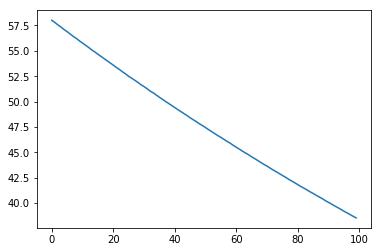

In [1025]:
plt.plot(train_hist['loss'].values)

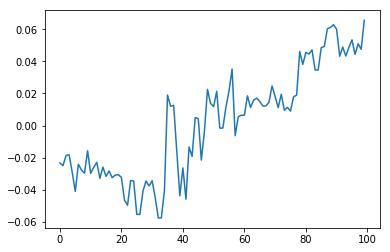

In [979]:
plt.plot(train_hist['val_sharpe'].values)

Testing

In [1010]:
agent.model.load_weights('PG/logs/model_epoch99.h5')

In [1011]:
agent.num_val = 600
agent.num_test = 600

In [1016]:
test_indices = np.arange(agent.num_train + agent.num_val, agent.num_train + agent.num_val + agent.num_test).reshape((-1, agent.traj_len))

Testing data

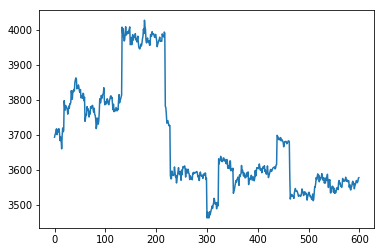

In [1017]:
plt.plot(data['Close'].values[np.arange(agent.num_train + agent.num_val, agent.num_train + agent.num_val + agent.num_test)])

Sharpe ratio if all the actions are long

In [1018]:
agent.sharpe_ratio(np.arange(agent.num_train + agent.num_val, agent.num_train + agent.num_val + agent.num_test), np.ones(agent.num_test, dtype = int))

-0.009819118260673568

Sharpe ratio using the strategy predicted by the agent

In [1019]:
agent.eva(test_indices)

validation sharpe ratio: 0.11079143590554417


0.11079143590554417

Plot cumulative rewards

In [1020]:
actions = agent.predict(agent.data_scaled[test_indices]).flatten()

In [1023]:
a = [agent.action_space[i] for i in actions]
a = np.array(a[:-1])
ret = np.diff(np.log(agent.data_raw[test_indices.flatten()][:,3])) * a

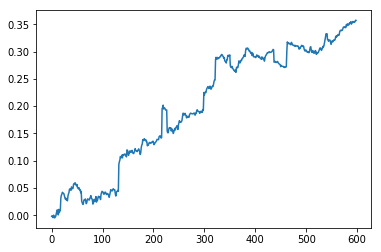

In [1024]:
plt.plot(np.cumsum(np.array(ret)))